# Data

In [23]:
import pandas as pd
import numpy as np

In [ ]:
#create a function to add a column sentence that indicates the sentence u=id for each txt file as a preprocessing step.

import pandas as pd
def data_conversion(file_name):
    df_eng=pd.read_csv(file_name,delimiter='\t',header=None,skip_blank_lines=False)
    df_eng.columns=['tag','tokens']
    tempTokens = list(df_eng['tokens'])
    tempSentence = list()
    count = 1
    for i in tempTokens:
        tempSentence.append("Sentence" + str(count))
        if str(i) == 'nan':
            count = count+1
    dfSentence = pd.DataFrame (tempSentence,columns=['Sentence']) 
    result = pd.concat([df_eng, dfSentence], axis=1, join='inner')
    return result

#passing the text files to function
trivia_train=data_conversion('trivia10k13train.txt')
trivia_test=data_conversion('trivia10k13test.txt')


In [8]:
trivia_train = pd.read_csv('trivia10k13train.bio.csv')
trivia_test = pd.read_csv('trivia10k13test.bio.csv')


In [9]:
trivia_train.head()
trivia_train.shape
trivia_train.tokens.nunique()
trivia_train.isnull().sum()

Unnamed: 0       0
tag           7816
tokens        7817
Sentence         0
dtype: int64

In [10]:
trivia_test.head()
trivia_test.shape
trivia_test.tokens.nunique()
trivia_test.isnull().sum()

Unnamed: 0       0
tag           1953
tokens        1953
Sentence         0
dtype: int64

In [11]:
trivia_train.dropna(inplace=True)
trivia_test.dropna(inplace=True)

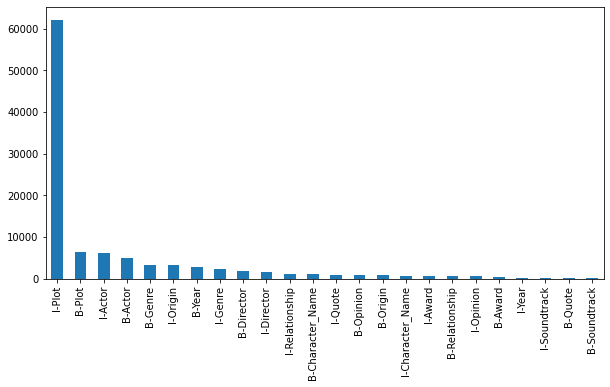

In [12]:
#below is the code to get the distribution plot for the tags.

trivia_train[trivia_train["tag"]!="O"]["tag"].value_counts().plot(kind="bar", figsize=(10,5))


In [13]:
data=trivia_train.copy()
data1=trivia_test.copy()


In [14]:
#Let us rename the column names using the below code:
data.rename(columns={"Sentence":"sentence_id","tokens":"words","tag":"labels"}, inplace =True)
data1.rename(columns={"Sentence":"sentence_id","tokens":"words","tag":"labels"}, inplace =True)

# CRF

In [16]:
!pip install sklearn-crfsuite

     |████████████████████████████████| 743 kB 33.0 MB/s 


In [18]:
!pip install eli5

     |████████████████████████████████| 106 kB 32.2 MB/s 


In [19]:
#For visualisation 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# For Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer

import scipy.stats
import eli5

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [20]:
class Get_Sent(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(a, b) for a,b in zip(s["words"].values.tolist(),
                                                        s["labels"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_id").apply(agg_func)
        self.sentences = [x for x in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

# calling the Get_Sent function and passing the train dataset      
Sent_get= Get_Sent(data)
sentences = Sent_get.sentences


In [21]:
# calling the Get_Sent function and passing the test dataset      

Sent_get= Get_Sent(data1)
sentences1 = Sent_get.sentences

#This is how a sentence will look like. 
print(sentences1[0])


[('i', 'O'), ('need', 'O'), ('that', 'O'), ('movie', 'O'), ('which', 'O'), ('involves', 'O'), ('aliens', 'B-Plot'), ('invading', 'I-Plot'), ('earth', 'I-Plot'), ('in', 'I-Plot'), ('a', 'I-Plot'), ('particular', 'I-Plot'), ('united', 'I-Plot'), ('states', 'I-Plot'), ('place', 'I-Plot'), ('in', 'I-Plot'), ('california', 'I-Plot')]


In [24]:
# feature mapping for the classifier. 

def create_ft(txt):
    return np.array([txt.istitle(), txt.islower(), txt.isupper(), 
len(txt),txt.isdigit(),  txt.isalpha()])

#using the above function created to get the mapping of words for train data.

words = [create_ft(x) for x in data["words"].values.tolist()]

#lets take unique labels
target = data["labels"].values.tolist()

#print few words with array
print(words[:5])



[array([0, 1, 0, 5, 0, 1]), array([0, 1, 0, 7, 0, 1]), array([0, 1, 0, 8, 0, 1]), array([0, 1, 0, 1, 0, 1]), array([0, 1, 0, 9, 0, 1])]


In [25]:
#using the above function created to get the mapping of words for test data.
words1 = [create_ft(x) for x in data1["words"].values.tolist()]
target1 = data1["labels"].values.tolist()


In [27]:
#importing package
from sklearn.model_selection import cross_val_predict

# train the RF model
Ner_prediction = cross_val_predict(RandomForestClassifier(n_estimators=20),X=words, y=target, cv=10)

#import library
from sklearn.metrics import classification_report

#generate report
Accuracy_rpt= classification_report(y_pred= Ner_prediction, y_true=target)
print(Accuracy_rpt)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.00      0.00      0.00      5010
         B-Award       0.00      0.00      0.00       309
B-Character_Name       0.00      0.00      0.00      1024
      B-Director       0.00      0.00      0.00      1787
         B-Genre       0.00      0.00      0.00      3384
       B-Opinion       0.00      0.00      0.00       810
        B-Origin       0.00      0.00      0.00       779
          B-Plot       0.00      0.00      0.00      6468
         B-Quote       0.00      0.00      0.00       126
  B-Relationship       0.00      0.00      0.00       580
    B-Soundtrack       0.00      0.00      0.00        50
          B-Year       0.88      0.99      0.93      2702
         I-Actor       0.51      0.01      0.01      6121
         I-Award       0.00      0.00      0.00       719
I-Character_Name       0.00      0.00      0.00       760
      I-Director       0.00      0.00      0.00      1653
         I-Ge

Feature mapping by adding more features:

In [30]:
from build_features import text_to_features

# function to create features
def text2num(wrd):
    return [text_to_features(wrd, i) for i in range(len(wrd))]

# function to create labels
def text2lbl(wrd):
    return [label for token,label in wrd]


In [32]:
X = [text2num(x) for x in sentences]
y = [text2lbl(x) for x in sentences]

In [33]:
test_X = [text2num(x) for x in sentences]
test_y = [text2lbl(x) for x in sentences]


In [35]:
#building the CRF model
ner_crf_model = CRF(algorithm='lbfgs',max_iterations=25)

#tgraining the model with cross validation of 10
ner_predictions = cross_val_predict(estimator=ner_crf_model, X=X, y=y, cv=10)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [36]:
Accu_rpt = flat_classification_report(y_pred=ner_predictions, y_true=y)
print(Accu_rpt)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.79      0.69      0.74      5010
         B-Award       0.00      0.00      0.00       309
B-Character_Name       0.41      0.02      0.03      1024
      B-Director       0.78      0.33      0.46      1787
         B-Genre       0.70      0.56      0.62      3384
       B-Opinion       0.45      0.29      0.35       810
        B-Origin       0.47      0.33      0.39       779
          B-Plot       0.40      0.39      0.40      6468
         B-Quote       0.00      0.00      0.00       126
  B-Relationship       0.76      0.03      0.06       580
    B-Soundtrack       0.00      0.00      0.00        50
          B-Year       0.94      0.96      0.95      2702
         I-Actor       0.79      0.65      0.71      6121
         I-Award       0.57      0.13      0.21       719
I-Character_Name       0.50      0.02      0.04       760
      I-Director       0.77      0.34      0.47      1653
         I-Ge

In [41]:
#building the CRF model
crf_ner = CRF(algorithm='lbfgs',max_iterations=25)

#Fitting model on train data.
crf_ner.fit(X,y)

# prediction on test data
test_prediction=crf_ner.predict(test_X)
# get labels
lbs=list(crf_ner.classes_)

#get accuracy
metrics.flat_f1_score(test_y,test_prediction,average='weighted',labels=lbs)


0.379142117036823

In [43]:
#sort the labels
sorted_lbs=sorted(lbs,key= lambda name:(name[1:],name[0]))

#get classification report
print(metrics.flat_classification_report(test_y,test_prediction,labels=sorted_lbs,digits=4))


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

               O     0.7103    0.2860    0.4078     55895
         B-Actor     0.0000    0.0000    0.0000      5010
         I-Actor     0.0000    0.0000    0.0000      6121
         B-Award     0.0000    0.0000    0.0000       309
         I-Award     0.0000    0.0000    0.0000       719
B-Character_Name     0.0000    0.0000    0.0000      1024
I-Character_Name     0.0000    0.0000    0.0000       760
      B-Director     0.0000    0.0000    0.0000      1787
      I-Director     0.0000    0.0000    0.0000      1653
         B-Genre     0.0000    0.0000    0.0000      3384
         I-Genre     0.0000    0.0000    0.0000      2283
       B-Opinion     0.0000    0.0000    0.0000       810
       I-Opinion     0.0000    0.0000    0.0000       539
        B-Origin     0.0000    0.0000    0.0000       779
        I-Origin     0.0000    0.0000    0.0000      3340
          B-Plot     0.0000    0.0000    0.0000      6468
          I-P

Prediction on random sentence:

In [47]:
def text_2_ftr_sample(words):
    return [text_to_features(words, i) for i in range(len(words))]

#define sample sentence
X_sample=['alien invasion is the movie directed by christoper nollen'.split()]

#convert to features 
X_sample1=[text_2_ftr_sample(x) for x in X_sample]

#predicting the class
crf_ner.predict(X_sample1)


[['I-Plot',
  'I-Plot',
  'I-Plot',
  'I-Plot',
  'I-Plot',
  'I-Plot',
  'I-Plot',
  'I-Plot',
  'I-Plot']]

# BERT Transformer

In [49]:
#!pip install simpletransformers

     |████████████████████████████████| 221 kB 31.4 MB/s 
     |████████████████████████████████| 2.8 MB 33.8 MB/s 
     |████████████████████████████████| 270 kB 66.0 MB/s 
     |████████████████████████████████| 1.7 MB 36.0 MB/s 
     |████████████████████████████████| 124 kB 54.1 MB/s 
     |████████████████████████████████| 8.0 MB 55.7 MB/s 
     |████████████████████████████████| 3.3 MB 27.0 MB/s 
     |████████████████████████████████| 1.2 MB 52.9 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 636 kB 62.1 MB/s 
     |████████████████████████████████| 895 kB 58.5 MB/s 
     |████████████████████████████████| 52 kB 1.8 MB/s 
     |████████████████████████████████| 133 kB 57.1 MB/s 
     |████████████████████████████████| 97 kB 7.0 MB/s 
     |████████████████████████████████| 180 kB 70.2 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 243 kB 72.4 MB/s 
     |████████████████

In [50]:
#importing necessary libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, make_scorer

#importing NER models from simple transformers
from simpletransformers.ner import NERModel,NERArgs

#importing libraries for evaluation
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import CRF, scorers, metrics


In [52]:
#encoding sentence values  
data["sentence_id"] = LabelEncoder().fit_transform(data["sentence_id"] )
data1["sentence_id"] = LabelEncoder().fit_transform(data1["sentence_id"] )

#converting labels to upper string as it is required format
data["labels"] = data["labels"].str.upper()
data1["labels"] = data1["labels"].str.upper()

X= data[["sentence_id","words"]]
Y =data["labels"]

#building up train and test data to dataframe 
ner_tr_dt = pd.DataFrame({"sentence_id":data["sentence_id"],"words":data["words"],"labels":data["labels"]})
test_data = pd.DataFrame({"sentence_id":data1["sentence_id"],"words":data1["words"],"labels":data1["labels"]})


In [53]:
#label values
label = ner_tr_dt["labels"].unique().tolist()


Training

In [ ]:
#fine tuning our model on custom data
args = NERArgs()

#set the # of epoch
args.num_train_epochs = 2

#learning reate
args.learning_rate = 1e-6
args.overwrite_output_dir =True

#train and evaluation batch size
args.train_batch_size = 6
args.eval_batch_size = 6

#initializing the model 
Ner_bert_mdl= NERModel('bert', 'bert-base-cased',labels=label,args =args,use_cuda=False)

#training our model
Ner_bert_mdl.train_model(ner_tr_dt,eval_data = test_data,acc=accuracy_score)

In [ ]:
function to store labels and words of each sentence in list 

class sent_generate(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        fn_group = lambda s: [(a, b) for a,b in zip(s["words"].values.tolist(),s["labels"].values.tolist())]
        self.grouped = self.data.groupby("sentence_id").apply(fn_group)
        self.sentences = [x for x in self.grouped]

#storing words and labels of each sentence in single list of train data

Sent_get= sent_generate(ner_tr_dt)
sentences = Sent_get.sentences

#This is how a sentence will look like. 
print(sentences[0])
def txt_2_lbs(sent):
    return [label for token,label in sent]

y_train_group = [txt_2_lbs(x) for x in sentences]


In [ ]:
#storing words and labels of each sentence in single list of test data
Sent_get= sent_generate(test_data)
sentences = Sent_get.sentences

#This is how a sentence will look like. 
print(sentences[0])

def txt_2_lbs(sent):
    return [label for token,label in sent]

y_test = [txt_2_lbs(x) for x in sentences] 


Evaluation

In [ ]:
#evaluating on test data
result, model_outputs, preds_list = Ner_bert_mdl.eval_model(test_data)

#individual group report 
accu_rpt = flat_classification_report(y_pred=preds_list, y_true=y_test)
print(accu_rpt)


In [ ]:
#evaluating on train data
result_train, model_outputs_train, preds_list_train = Ner_bert_mdl.eval_model(ner_tr_dt)

#individual group report of train data
report_train = flat_classification_report(y_pred=preds_list, y_true=y_train_group)
print(report_train)


Predicting on sentence

In [ ]:
prediction, model_output = Ner_bert_mdl.predict(["aliens invading is movie by christoper nollen"])